In [1]:
from astropy.io import fits
import astropy.units as u
import exoscene.star
import numpy as np
import os
import time
import pandas as pd

from pastis.config import CONFIG_PASTIS
from pastis.matrix_generation.matrix_from_efields import MatrixEfieldHex
from pastis.pastis_analysis import calculate_segment_constraints
from pastis.util import dh_mean

from ultra.config import CONFIG_ULTRA
from ultra.util import calculate_sensitivity_matrices
from ultra.close_loop_analysis import req_closedloop_calc_batch
from ultra.plotting import plot_iter_wf
import matplotlib.pyplot as plt

## One ring 

In [2]:
NUM_RINGS = 1
WHICH_DM = 'seg_mirror'

# Define target contrast
C_TARGET = 1e-11

# Parameters for Temporal Ananlysis
sptype = CONFIG_ULTRA.get('target', 'sptype')
# Vmag = CONFIG_ULTRA.getfloat('target', 'Vmag')

minlam = CONFIG_ULTRA.getfloat('target', 'minlam') * u.nanometer
maxlam = CONFIG_ULTRA.getfloat('target', 'maxlam') * u.nanometer

dark_current = CONFIG_ULTRA.getfloat('detector', 'dark_current')
CIC = CONFIG_ULTRA.getfloat('detector', 'dark_current')

# Set close loop parameters.
detector_noise = CONFIG_ULTRA.getfloat('detector', 'detector_noise')
niter = CONFIG_ULTRA.getint('close_loop', 'niter')
TimeMinus = CONFIG_ULTRA.getfloat('close_loop', 'TimeMinus')
TimePlus = CONFIG_ULTRA.getfloat('close_loop', 'TimePlus')
Ntimes = CONFIG_ULTRA.getint('close_loop', 'Ntimes')
Nwavescale = CONFIG_ULTRA.getfloat('close_loop', 'Nwavescale')

# if WHICH_DM == 'harris_seg_mirror':
#     fpath = CONFIG_PASTIS.get('LUVOIR', 'harris_data_path')  # path to Harris spreadsheet
#     pad_orientations = np.pi / 2 * np.ones(CONFIG_PASTIS.getint('LUVOIR', 'nb_subapertures'))
#     DM_SPEC = (fpath, pad_orientations, True, False, False)
#     NUM_MODES = 7

# DM_SPEC = 7
# NUM_MODES = 7
# run_matrix = MatrixEfieldHex(which_dm=WHICH_DM, dm_spec=DM_SPEC, num_rings=NUM_RINGS,
#                              calc_science=True, calc_wfs=True,
#                              initial_path=CONFIG_PASTIS.get('local', 'local_data_path'), norm_one_photon=True)

# run_matrix.calc()
# data_dir = run_matrix.overall_dir
# print(f'All saved to {data_dir}.')

# tel = run_matrix.simulator


# unaber_psf = fits.getdata(os.path.join(data_dir, 'unaberrated_coro_psf.fits'))  # already normalized to max of direct psf
# dh_mask_shaped = tel.dh_mask.shaped
# contrast_floor = dh_mean(unaber_psf, dh_mask_shaped)

In [3]:
data_dir = '/Users/pueyo/data_from_repos/pastis_data/2023-05-26T16-43-23_hexringtelescope/'

vmag_array = np.arange(0, 11, 2)
wavescale_min = 1    
wavescale_max = 301
wavescale_step = 25
wavescale_array =  np.arange(wavescale_min, wavescale_max, wavescale_step)
N_wave = len(wavescale_array)
TimeMinus = -2
TimePlus = 5.5
Ntimes = 20
time_array = np.logspace(TimeMinus, TimePlus, Ntimes)

wavescale_step_fine = 1
wavescale_array_fine =  np.arange(wavescale_min, wavescale_max, wavescale_step_fine)
vmag_array_fine = np.arange(0, 11, 0.05)

mus = np.genfromtxt(data_dir+'mus_Hex_1_1e-11.csv',delimiter=',')
Qs = np.diag(np.asarray(mus ** 2))
delta_wf = []
for wavescale in range(wavescale_min, wavescale_max, wavescale_step):
    wf = np.sqrt(np.mean(np.diag(0.0001 * wavescale ** 2 * Qs))) * 1e3
    delta_wf.append(wf)
delta_wf = np.array(delta_wf)
Nwf = len(delta_wf)
delta_wf_fine = []
for wavescale in range(wavescale_min, wavescale_max, wavescale_step_fine):
    wf = np.sqrt(np.mean(np.diag(0.0001 * wavescale ** 2 * Qs))) * 1e3
    delta_wf_fine.append(wf)
delta_wf_fine = np.array(delta_wf_fine)

unarchive_data_mag0 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_1_0.csv',delimiter=',')
unarchive_data_mag2 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_1_2.csv',delimiter=',')
unarchive_data_mag4 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_1_4.csv',delimiter=',')
unarchive_data_mag6 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_1_6.csv',delimiter=',')
unarchive_data_mag8 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_1_8.csv',delimiter=',')
unarchive_data_mag10 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_1_10.csv',delimiter=',')

### just make the plots

0.20253759398496238
[ 0.2065125  -0.32468636]
-0.9456931292163874
[-0.89120435 -0.32468636]
0.19837514328623615
[  0.19907064 -11.86012993]
1.006028570583132
[  1.01556255 -11.86012993]


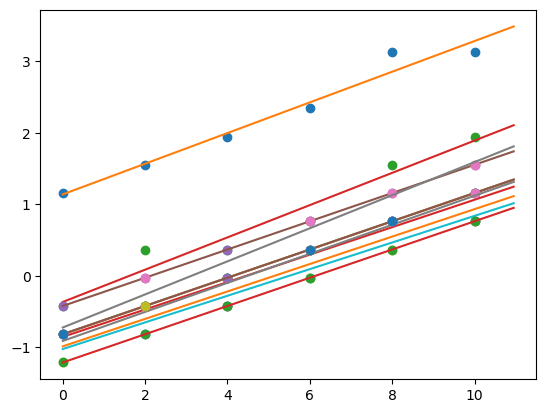

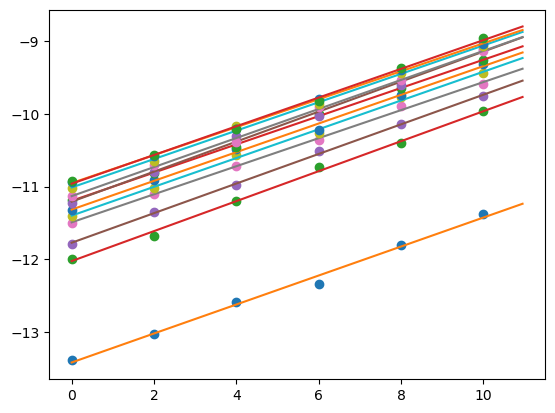

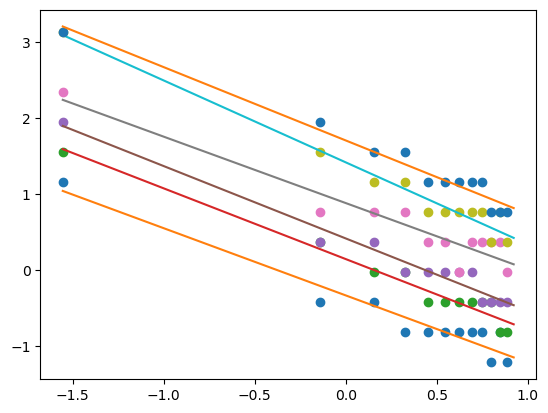

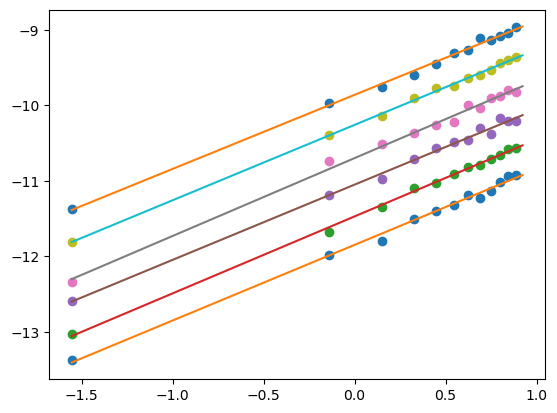

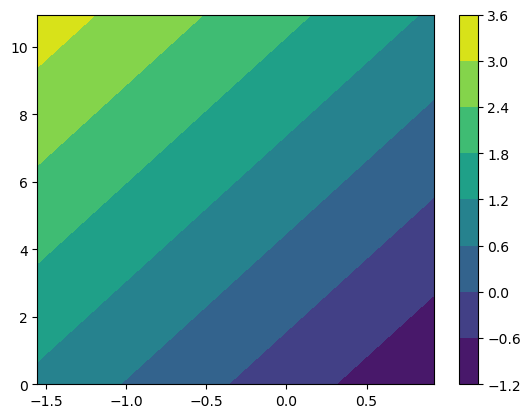

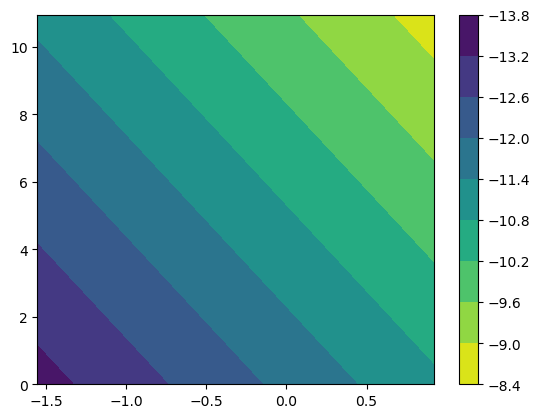

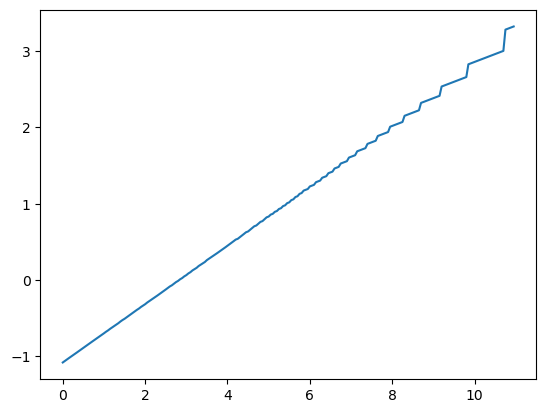

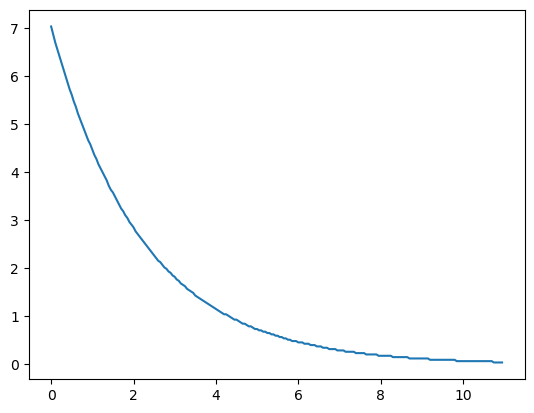

In [4]:
unarchive_data = np.concatenate((unarchive_data_mag0,unarchive_data_mag2,unarchive_data_mag4,unarchive_data_mag6,unarchive_data_mag8,unarchive_data_mag10))
t_min =  np.zeros([len(vmag_array),len(delta_wf)])
C_min =  np.zeros([len(vmag_array),len(delta_wf)])
for kk in range(0,len(vmag_array)):
    for qq in range(0,len(delta_wf)): 
        small_index = kk*(Ntimes*Nwf)+qq*Ntimes
        large_index = kk*(Ntimes*Nwf)+(qq+1)*Ntimes
        trou = unarchive_data[small_index:large_index]
        C_min[kk,qq] = np.min(trou)
        t_min[kk,qq] = time_array[trou == np.min(trou)]
def make_interp_plot(coarse_x,coarse_y,fine_x):
    z = np.polyfit(coarse_x, coarse_y, 1)
    fine_y = np.polyval(z, fine_x)
    plt.plot(coarse_x,coarse_y,'o')
    plt.plot(fine_x,fine_y)
    return (fine_y,z)
t_min_fine_vmag = np.zeros([len(vmag_array_fine),len(delta_wf)])
t_min_fit_vmag = np.zeros([len(delta_wf),2])
plt.figure()
for kk in range(0,len(delta_wf)):
    t_min_fine_vmag[:,kk],t_min_fit_vmag[kk] = make_interp_plot(vmag_array,np.log10(t_min[:,kk]),vmag_array_fine)
C_min_fine_vmag = np.zeros([len(vmag_array_fine),len(delta_wf)])
C_min_fit_vmag = np.zeros([len(delta_wf),2])
plt.figure()
for kk in range(0,len(delta_wf)):
    C_min_fine_vmag[:,kk],C_min_fit_vmag[kk,:] = make_interp_plot(vmag_array,np.log10(C_min[:,kk]),vmag_array_fine)
t_min_fine_wf = np.zeros([len(vmag_array),len(delta_wf_fine)])
t_min_fit_wf = np.zeros([len(vmag_array),2])
plt.figure()
for kk in range(0,len(vmag_array)):
    t_min_fine_wf[kk,:],t_min_fit_wf[kk,:] = make_interp_plot(np.log10(delta_wf),np.log10(t_min[kk,:]),np.log10(delta_wf_fine))
C_min_fine_wf = np.zeros([len(vmag_array),len(delta_wf_fine)])
C_min_fit_wf = np.zeros([len(vmag_array),2])
plt.figure()
for kk in range(0,len(vmag_array)):
    C_min_fine_wf[kk,:],C_min_fit_wf[kk,:] = make_interp_plot(np.log10(delta_wf),np.log10(C_min[kk,:]),np.log10(delta_wf_fine))
z_t_min_wf = np.polyfit(np.log10(delta_wf),t_min_fit_vmag[:,1], 1)
z_C_min_wf = np.polyfit(np.log10(delta_wf),C_min_fit_vmag[:,1], 1)
z_t_min_vmag = np.polyfit(vmag_array,t_min_fit_wf[:,1], 1)
z_C_min_vmag = np.polyfit(vmag_array,C_min_fit_wf[:,1], 1)
Nvmag =  len(vmag_array_fine)
Nwf_fine =  len(delta_wf_fine)
ones_vmag = np.ones([1,Nvmag])
ones_wf = np.ones([1,Nwf_fine])
delta_wf_line = np.dot(np.transpose([delta_wf_fine]),ones_vmag)
vmag_column = np.dot(np.transpose(ones_wf),[vmag_array_fine])
t_min_2D = z_t_min_vmag[1]+z_t_min_wf[0]*np.log10(delta_wf_line)+z_t_min_vmag[0]*vmag_column
C_min_2D = z_C_min_vmag[1]+z_C_min_wf[0]*np.log10(delta_wf_line)+z_C_min_vmag[0]*vmag_column
plt.figure()
plt.contourf(np.log10(delta_wf_line),vmag_column,t_min_2D)
plt.colorbar()
plt.figure()
plt.contourf(np.log10(delta_wf_line),vmag_column,C_min_2D)
plt.colorbar()
print(np.mean(t_min_fit_vmag[:,0]))
print(z_t_min_vmag)
print(np.mean(t_min_fit_wf[:,0]))
print(z_t_min_wf)
print(np.mean(C_min_fit_vmag[:,0]))
print(z_C_min_vmag)
print(np.mean(C_min_fit_wf[:,0]))
print(z_C_min_wf)
wf_req = np.zeros(Nvmag)
t_req = np.zeros(Nvmag)
for kk in range(0,Nvmag):
    if len(delta_wf_fine[C_min_2D[:,kk]<-11]) == 0: 
        wf_req_log = np.min(delta_wf_fine)
    else:
        wf_req_log = np.max(delta_wf_fine[C_min_2D[:,kk]<-11])
    wf_req[kk] = wf_req_log
    t_req_log = t_min_2D[delta_wf_fine == wf_req_log,kk]
    t_req[kk] = 10**(t_req_log)
plt.figure()
plt.plot(vmag_array_fine,np.log10(t_req))
plt.figure()
plt.plot(vmag_array_fine,wf_req)
t_req_1ring = t_req
wf_req_1ring = wf_req

## Two rings

In [5]:
NUM_RINGS = 2
WHICH_DM = 'seg_mirror'

# Define target contrast
C_TARGET = 1e-11

# Parameters for Temporal Ananlysis
sptype = CONFIG_ULTRA.get('target', 'sptype')
# Vmag = CONFIG_ULTRA.getfloat('target', 'Vmag')

minlam = CONFIG_ULTRA.getfloat('target', 'minlam') * u.nanometer
maxlam = CONFIG_ULTRA.getfloat('target', 'maxlam') * u.nanometer

dark_current = CONFIG_ULTRA.getfloat('detector', 'dark_current')
CIC = CONFIG_ULTRA.getfloat('detector', 'dark_current')

# Set close loop parameters.
detector_noise = CONFIG_ULTRA.getfloat('detector', 'detector_noise')
niter = CONFIG_ULTRA.getint('close_loop', 'niter')
TimeMinus = CONFIG_ULTRA.getfloat('close_loop', 'TimeMinus')
TimePlus = CONFIG_ULTRA.getfloat('close_loop', 'TimePlus')
Ntimes = CONFIG_ULTRA.getint('close_loop', 'Ntimes')
Nwavescale = CONFIG_ULTRA.getfloat('close_loop', 'Nwavescale')

# if WHICH_DM == 'harris_seg_mirror':
#     fpath = CONFIG_PASTIS.get('LUVOIR', 'harris_data_path')  # path to Harris spreadsheet
#     pad_orientations = np.pi / 2 * np.ones(CONFIG_PASTIS.getint('LUVOIR', 'nb_subapertures'))
#     DM_SPEC = (fpath, pad_orientations, True, False, False)
#     NUM_MODES = 7

# DM_SPEC = 7
# NUM_MODES = 7
# run_matrix = MatrixEfieldHex(which_dm=WHICH_DM, dm_spec=DM_SPEC, num_rings=NUM_RINGS,
#                              calc_science=True, calc_wfs=True,
#                              initial_path=CONFIG_PASTIS.get('local', 'local_data_path'), norm_one_photon=True)

# run_matrix.calc()
# data_dir = run_matrix.overall_dir
# print(f'All saved to {data_dir}.')

# tel = run_matrix.simulator


# unaber_psf = fits.getdata(os.path.join(data_dir, 'unaberrated_coro_psf.fits'))  # already normalized to max of direct psf
# dh_mask_shaped = tel.dh_mask.shaped
# contrast_floor = dh_mean(unaber_psf, dh_mask_shaped)

In [6]:
data_dir = '/Users/pueyo/data_from_repos/pastis_data/2023-05-26T16-51-20_hexringtelescope/'

vmag_array = np.arange(0, 11, 2)
wavescale_min = 1    
wavescale_max = 301
wavescale_step = 25
wavescale_array =  np.arange(wavescale_min, wavescale_max, wavescale_step)
N_wave = len(wavescale_array)
TimeMinus = -2
TimePlus = 5.5
Ntimes = 20
time_array = np.logspace(TimeMinus, TimePlus, Ntimes)

wavescale_step_fine = 1
wavescale_array_fine =  np.arange(wavescale_min, wavescale_max, wavescale_step_fine)
vmag_array_fine = np.arange(0, 11, 0.05)

mus = np.genfromtxt(data_dir+'mus_Hex_2_1e-11.csv',delimiter=',')
Qs = np.diag(np.asarray(mus ** 2))
delta_wf = []
for wavescale in range(wavescale_min, wavescale_max, wavescale_step):
    wf = np.sqrt(np.mean(np.diag(0.0001 * wavescale ** 2 * Qs))) * 1e3
    delta_wf.append(wf)
delta_wf = np.array(delta_wf)
Nwf = len(delta_wf)
delta_wf_fine = []
for wavescale in range(wavescale_min, wavescale_max, wavescale_step_fine):
    wf = np.sqrt(np.mean(np.diag(0.0001 * wavescale ** 2 * Qs))) * 1e3
    delta_wf_fine.append(wf)
delta_wf_fine = np.array(delta_wf_fine)

unarchive_data_mag0 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_2_0.csv',delimiter=',')
unarchive_data_mag2 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_2_2.csv',delimiter=',')
unarchive_data_mag4 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_2_4.csv',delimiter=',')
unarchive_data_mag6 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_2_6.csv',delimiter=',')
unarchive_data_mag8 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_2_8.csv',delimiter=',')
unarchive_data_mag10 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_2_10.csv',delimiter=',')

### just make the plots

0.1945488721804511
[0.19485886 0.01653686]
-0.9994518246934362
[-0.9950041   0.01653686]
0.19953875894186382
[  0.19994351 -11.54131808]
0.9992132232292256
[  1.00502062 -11.54131808]


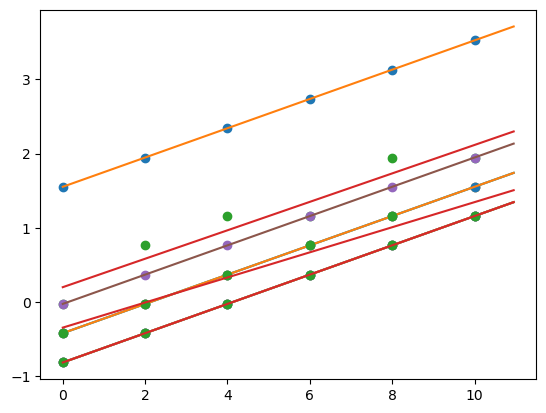

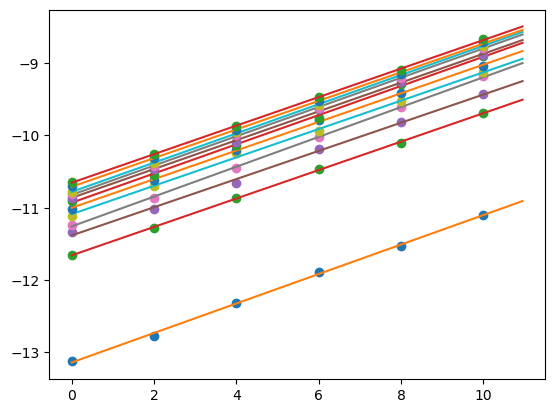

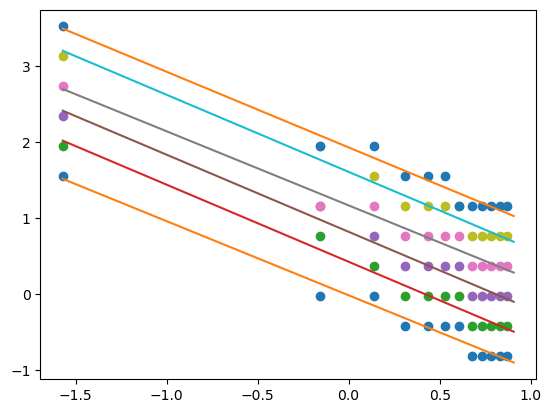

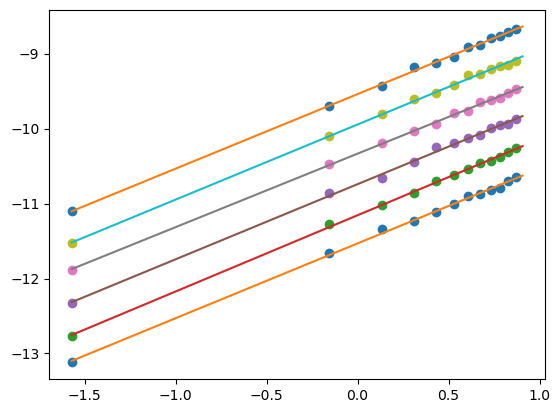

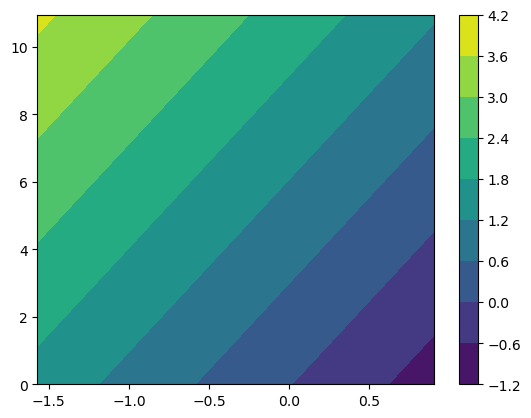

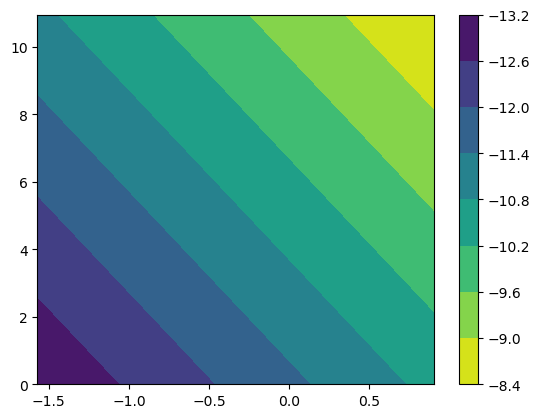

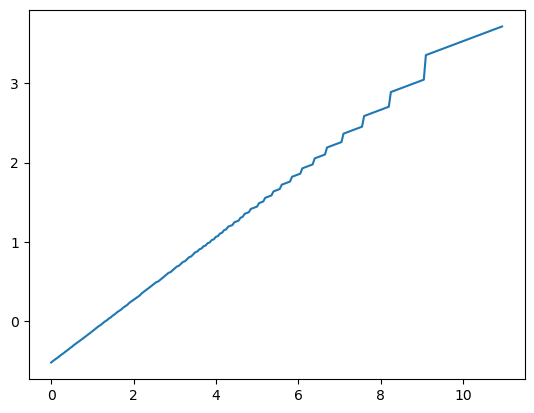

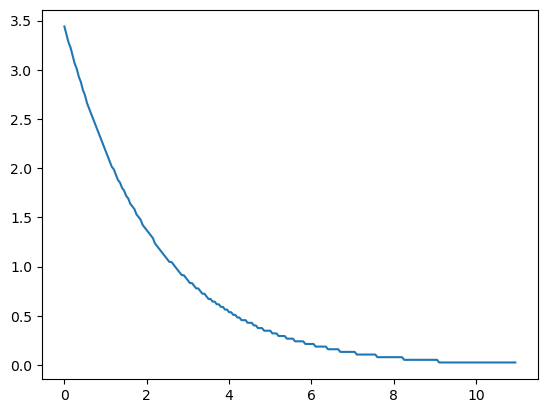

In [7]:
unarchive_data = np.concatenate((unarchive_data_mag0,unarchive_data_mag2,unarchive_data_mag4,unarchive_data_mag6,unarchive_data_mag8,unarchive_data_mag10))
t_min =  np.zeros([len(vmag_array),len(delta_wf)])
C_min =  np.zeros([len(vmag_array),len(delta_wf)])
for kk in range(0,len(vmag_array)):
    for qq in range(0,len(delta_wf)): 
        small_index = kk*(Ntimes*Nwf)+qq*Ntimes
        large_index = kk*(Ntimes*Nwf)+(qq+1)*Ntimes
        trou = unarchive_data[small_index:large_index]
        C_min[kk,qq] = np.min(trou)
        t_min[kk,qq] = time_array[trou == np.min(trou)]
def make_interp_plot(coarse_x,coarse_y,fine_x):
    z = np.polyfit(coarse_x, coarse_y, 1)
    fine_y = np.polyval(z, fine_x)
    plt.plot(coarse_x,coarse_y,'o')
    plt.plot(fine_x,fine_y)
    return (fine_y,z)
t_min_fine_vmag = np.zeros([len(vmag_array_fine),len(delta_wf)])
t_min_fit_vmag = np.zeros([len(delta_wf),2])
plt.figure()
for kk in range(0,len(delta_wf)):
    t_min_fine_vmag[:,kk],t_min_fit_vmag[kk] = make_interp_plot(vmag_array,np.log10(t_min[:,kk]),vmag_array_fine)
C_min_fine_vmag = np.zeros([len(vmag_array_fine),len(delta_wf)])
C_min_fit_vmag = np.zeros([len(delta_wf),2])
plt.figure()
for kk in range(0,len(delta_wf)):
    C_min_fine_vmag[:,kk],C_min_fit_vmag[kk,:] = make_interp_plot(vmag_array,np.log10(C_min[:,kk]),vmag_array_fine)
t_min_fine_wf = np.zeros([len(vmag_array),len(delta_wf_fine)])
t_min_fit_wf = np.zeros([len(vmag_array),2])
plt.figure()
for kk in range(0,len(vmag_array)):
    t_min_fine_wf[kk,:],t_min_fit_wf[kk,:] = make_interp_plot(np.log10(delta_wf),np.log10(t_min[kk,:]),np.log10(delta_wf_fine))
C_min_fine_wf = np.zeros([len(vmag_array),len(delta_wf_fine)])
C_min_fit_wf = np.zeros([len(vmag_array),2])
plt.figure()
for kk in range(0,len(vmag_array)):
    C_min_fine_wf[kk,:],C_min_fit_wf[kk,:] = make_interp_plot(np.log10(delta_wf),np.log10(C_min[kk,:]),np.log10(delta_wf_fine))
z_t_min_wf = np.polyfit(np.log10(delta_wf),t_min_fit_vmag[:,1], 1)
z_C_min_wf = np.polyfit(np.log10(delta_wf),C_min_fit_vmag[:,1], 1)
z_t_min_vmag = np.polyfit(vmag_array,t_min_fit_wf[:,1], 1)
z_C_min_vmag = np.polyfit(vmag_array,C_min_fit_wf[:,1], 1)
Nvmag =  len(vmag_array_fine)
Nwf_fine =  len(delta_wf_fine)
ones_vmag = np.ones([1,Nvmag])
ones_wf = np.ones([1,Nwf_fine])
delta_wf_line = np.dot(np.transpose([delta_wf_fine]),ones_vmag)
vmag_column = np.dot(np.transpose(ones_wf),[vmag_array_fine])
t_min_2D = z_t_min_vmag[1]+z_t_min_wf[0]*np.log10(delta_wf_line)+z_t_min_vmag[0]*vmag_column
C_min_2D = z_C_min_vmag[1]+z_C_min_wf[0]*np.log10(delta_wf_line)+z_C_min_vmag[0]*vmag_column
plt.figure()
plt.contourf(np.log10(delta_wf_line),vmag_column,t_min_2D)
plt.colorbar()
plt.figure()
plt.contourf(np.log10(delta_wf_line),vmag_column,C_min_2D)
plt.colorbar()
print(np.mean(t_min_fit_vmag[:,0]))
print(z_t_min_vmag)
print(np.mean(t_min_fit_wf[:,0]))
print(z_t_min_wf)
print(np.mean(C_min_fit_vmag[:,0]))
print(z_C_min_vmag)
print(np.mean(C_min_fit_wf[:,0]))
print(z_C_min_wf)
wf_req = np.zeros(Nvmag)
t_req = np.zeros(Nvmag)
for kk in range(0,Nvmag):
    if len(delta_wf_fine[C_min_2D[:,kk]<-11]) == 0: 
        wf_req_log = np.min(delta_wf_fine)
    else:
        wf_req_log = np.max(delta_wf_fine[C_min_2D[:,kk]<-11])
    wf_req[kk] = wf_req_log
    t_req_log = t_min_2D[delta_wf_fine == wf_req_log,kk]
    t_req[kk] = 10**(t_req_log)
plt.figure()
plt.plot(vmag_array_fine,np.log10(t_req))
plt.figure()
plt.plot(vmag_array_fine,wf_req)
t_req_2ring = t_req
wf_req_2ring = wf_req

## Three rings

In [8]:
NUM_RINGS = 3
WHICH_DM = 'seg_mirror'

# Define target contrast
C_TARGET = 1e-11

# Parameters for Temporal Ananlysis
sptype = CONFIG_ULTRA.get('target', 'sptype')
# Vmag = CONFIG_ULTRA.getfloat('target', 'Vmag')

minlam = CONFIG_ULTRA.getfloat('target', 'minlam') * u.nanometer
maxlam = CONFIG_ULTRA.getfloat('target', 'maxlam') * u.nanometer

dark_current = CONFIG_ULTRA.getfloat('detector', 'dark_current')
CIC = CONFIG_ULTRA.getfloat('detector', 'dark_current')

# Set close loop parameters.
detector_noise = CONFIG_ULTRA.getfloat('detector', 'detector_noise')
niter = CONFIG_ULTRA.getint('close_loop', 'niter')
TimeMinus = CONFIG_ULTRA.getfloat('close_loop', 'TimeMinus')
TimePlus = CONFIG_ULTRA.getfloat('close_loop', 'TimePlus')
Ntimes = CONFIG_ULTRA.getint('close_loop', 'Ntimes')
Nwavescale = CONFIG_ULTRA.getfloat('close_loop', 'Nwavescale')

# if WHICH_DM == 'harris_seg_mirror':
#     fpath = CONFIG_PASTIS.get('LUVOIR', 'harris_data_path')  # path to Harris spreadsheet
#     pad_orientations = np.pi / 2 * np.ones(CONFIG_PASTIS.getint('LUVOIR', 'nb_subapertures'))
#     DM_SPEC = (fpath, pad_orientations, True, False, False)
#     NUM_MODES = 7

# DM_SPEC = 7
# NUM_MODES = 7
# run_matrix = MatrixEfieldHex(which_dm=WHICH_DM, dm_spec=DM_SPEC, num_rings=NUM_RINGS,
#                              calc_science=True, calc_wfs=True,
#                              initial_path=CONFIG_PASTIS.get('local', 'local_data_path'), norm_one_photon=True)

# run_matrix.calc()
# data_dir = run_matrix.overall_dir
# print(f'All saved to {data_dir}.')

# tel = run_matrix.simulator


# unaber_psf = fits.getdata(os.path.join(data_dir, 'unaberrated_coro_psf.fits'))  # already normalized to max of direct psf
# dh_mask_shaped = tel.dh_mask.shaped
# contrast_floor = dh_mean(unaber_psf, dh_mask_shaped)

In [9]:
data_dir = '/Users/pueyo/data_from_repos/pastis_data/2023-05-26T17-23-51_hexringtelescope/'

vmag_array = np.arange(0, 11, 2)
wavescale_min = 1    
wavescale_max = 301
wavescale_step = 25
wavescale_array =  np.arange(wavescale_min, wavescale_max, wavescale_step)
N_wave = len(wavescale_array)
TimeMinus = -2
TimePlus = 5.5
Ntimes = 20
time_array = np.logspace(TimeMinus, TimePlus, Ntimes)

wavescale_step_fine = 1
wavescale_array_fine =  np.arange(wavescale_min, wavescale_max, wavescale_step_fine)
vmag_array_fine = np.arange(0, 11, 0.05)

mus = np.genfromtxt(data_dir+'mus_Hex_3_1e-11.csv',delimiter=',')
Qs = np.diag(np.asarray(mus ** 2))
delta_wf = []
for wavescale in range(wavescale_min, wavescale_max, wavescale_step):
    wf = np.sqrt(np.mean(np.diag(0.0001 * wavescale ** 2 * Qs))) * 1e3
    delta_wf.append(wf)
delta_wf = np.array(delta_wf)
Nwf = len(delta_wf)
delta_wf_fine = []
for wavescale in range(wavescale_min, wavescale_max, wavescale_step_fine):
    wf = np.sqrt(np.mean(np.diag(0.0001 * wavescale ** 2 * Qs))) * 1e3
    delta_wf_fine.append(wf)
delta_wf_fine = np.array(delta_wf_fine)

unarchive_data_mag0 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_3_0.csv',delimiter=',')
unarchive_data_mag2 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_3_2.csv',delimiter=',')
unarchive_data_mag4 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_3_4.csv',delimiter=',')
unarchive_data_mag6 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_3_6.csv',delimiter=',')
unarchive_data_mag8 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_3_8.csv',delimiter=',')
unarchive_data_mag10 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_3_10.csv',delimiter=',')

### just make the plots

0.1968984962406015
[0.19700369 0.46259988]
-0.991906277762248
[-0.99089226  0.46259988]
0.20107596519776882
[  0.2014068  -11.46195122]
0.9989801739950588
[  1.00216925 -11.46195122]


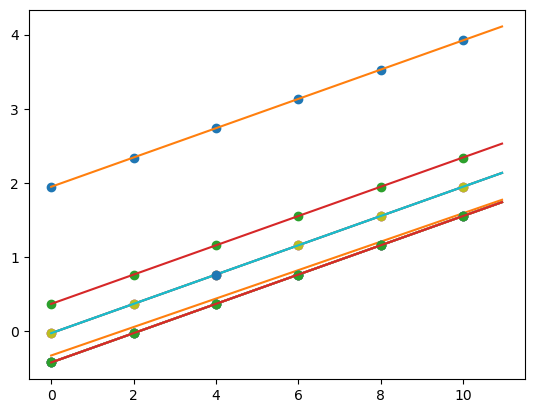

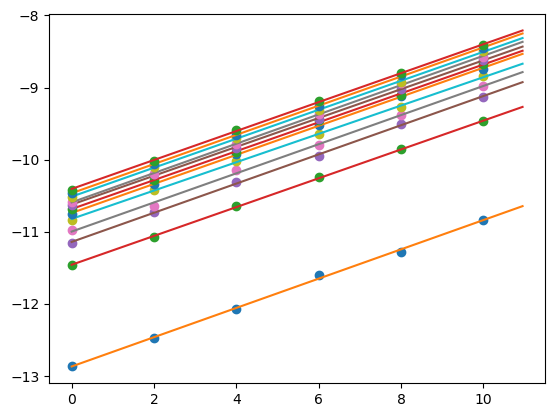

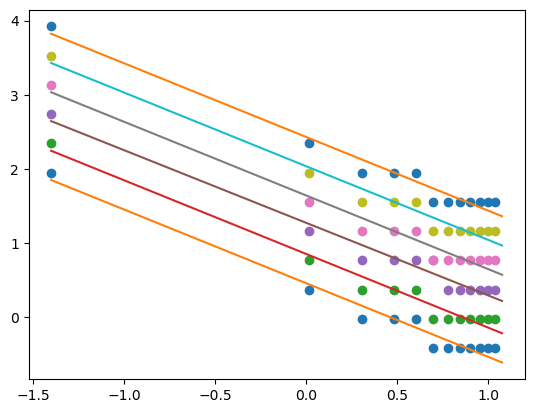

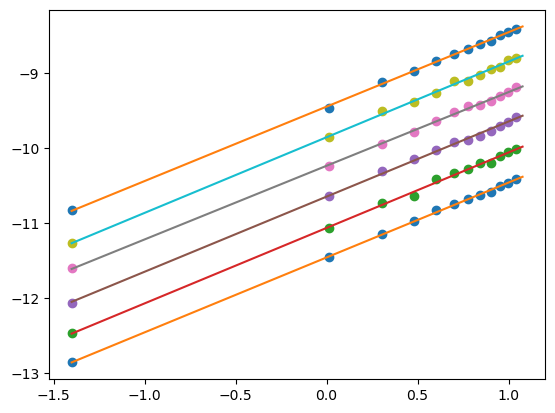

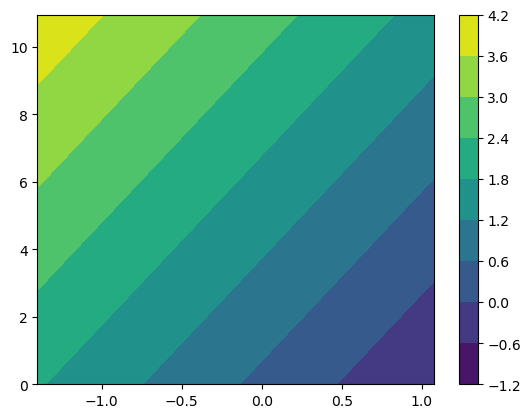

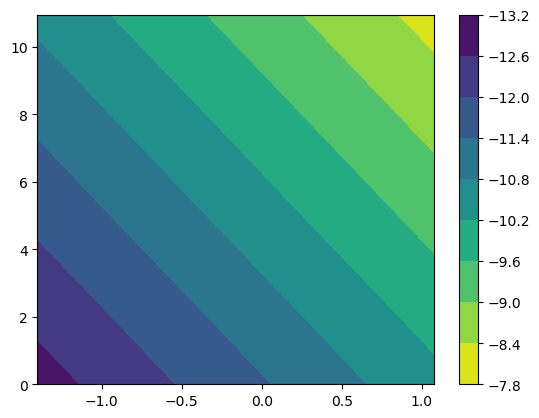

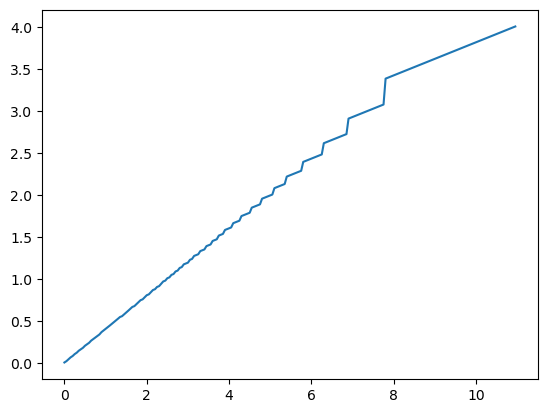

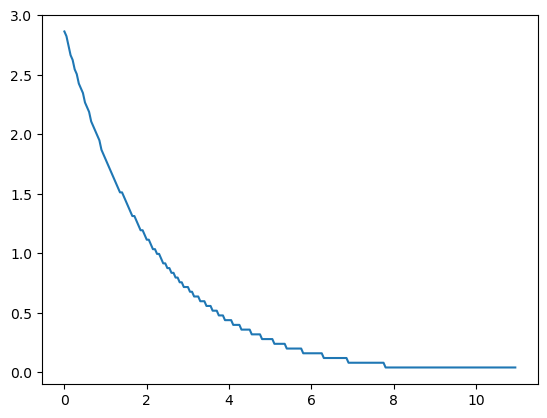

In [10]:
unarchive_data = np.concatenate((unarchive_data_mag0,unarchive_data_mag2,unarchive_data_mag4,unarchive_data_mag6,unarchive_data_mag8,unarchive_data_mag10))
t_min =  np.zeros([len(vmag_array),len(delta_wf)])
C_min =  np.zeros([len(vmag_array),len(delta_wf)])
for kk in range(0,len(vmag_array)):
    for qq in range(0,len(delta_wf)): 
        small_index = kk*(Ntimes*Nwf)+qq*Ntimes
        large_index = kk*(Ntimes*Nwf)+(qq+1)*Ntimes
        trou = unarchive_data[small_index:large_index]
        C_min[kk,qq] = np.min(trou)
        t_min[kk,qq] = time_array[trou == np.min(trou)]
def make_interp_plot(coarse_x,coarse_y,fine_x):
    z = np.polyfit(coarse_x, coarse_y, 1)
    fine_y = np.polyval(z, fine_x)
    plt.plot(coarse_x,coarse_y,'o')
    plt.plot(fine_x,fine_y)
    return (fine_y,z)
t_min_fine_vmag = np.zeros([len(vmag_array_fine),len(delta_wf)])
t_min_fit_vmag = np.zeros([len(delta_wf),2])
plt.figure()
for kk in range(0,len(delta_wf)):
    t_min_fine_vmag[:,kk],t_min_fit_vmag[kk] = make_interp_plot(vmag_array,np.log10(t_min[:,kk]),vmag_array_fine)
C_min_fine_vmag = np.zeros([len(vmag_array_fine),len(delta_wf)])
C_min_fit_vmag = np.zeros([len(delta_wf),2])
plt.figure()
for kk in range(0,len(delta_wf)):
    C_min_fine_vmag[:,kk],C_min_fit_vmag[kk,:] = make_interp_plot(vmag_array,np.log10(C_min[:,kk]),vmag_array_fine)
t_min_fine_wf = np.zeros([len(vmag_array),len(delta_wf_fine)])
t_min_fit_wf = np.zeros([len(vmag_array),2])
plt.figure()
for kk in range(0,len(vmag_array)):
    t_min_fine_wf[kk,:],t_min_fit_wf[kk,:] = make_interp_plot(np.log10(delta_wf),np.log10(t_min[kk,:]),np.log10(delta_wf_fine))
C_min_fine_wf = np.zeros([len(vmag_array),len(delta_wf_fine)])
C_min_fit_wf = np.zeros([len(vmag_array),2])
plt.figure()
for kk in range(0,len(vmag_array)):
    C_min_fine_wf[kk,:],C_min_fit_wf[kk,:] = make_interp_plot(np.log10(delta_wf),np.log10(C_min[kk,:]),np.log10(delta_wf_fine))
z_t_min_wf = np.polyfit(np.log10(delta_wf),t_min_fit_vmag[:,1], 1)
z_C_min_wf = np.polyfit(np.log10(delta_wf),C_min_fit_vmag[:,1], 1)
z_t_min_vmag = np.polyfit(vmag_array,t_min_fit_wf[:,1], 1)
z_C_min_vmag = np.polyfit(vmag_array,C_min_fit_wf[:,1], 1)
Nvmag =  len(vmag_array_fine)
Nwf_fine =  len(delta_wf_fine)
ones_vmag = np.ones([1,Nvmag])
ones_wf = np.ones([1,Nwf_fine])
delta_wf_line = np.dot(np.transpose([delta_wf_fine]),ones_vmag)
vmag_column = np.dot(np.transpose(ones_wf),[vmag_array_fine])
t_min_2D = z_t_min_vmag[1]+z_t_min_wf[0]*np.log10(delta_wf_line)+z_t_min_vmag[0]*vmag_column
C_min_2D = z_C_min_vmag[1]+z_C_min_wf[0]*np.log10(delta_wf_line)+z_C_min_vmag[0]*vmag_column
plt.figure()
plt.contourf(np.log10(delta_wf_line),vmag_column,t_min_2D)
plt.colorbar()
plt.figure()
plt.contourf(np.log10(delta_wf_line),vmag_column,C_min_2D)
plt.colorbar()
print(np.mean(t_min_fit_vmag[:,0]))
print(z_t_min_vmag)
print(np.mean(t_min_fit_wf[:,0]))
print(z_t_min_wf)
print(np.mean(C_min_fit_vmag[:,0]))
print(z_C_min_vmag)
print(np.mean(C_min_fit_wf[:,0]))
print(z_C_min_wf)
wf_req = np.zeros(Nvmag)
t_req = np.zeros(Nvmag)
for kk in range(0,Nvmag):
    if len(delta_wf_fine[C_min_2D[:,kk]<-11]) == 0: 
        wf_req_log = np.min(delta_wf_fine)
    else:
        wf_req_log = np.max(delta_wf_fine[C_min_2D[:,kk]<-11])
    wf_req[kk] = wf_req_log
    t_req_log = t_min_2D[delta_wf_fine == wf_req_log,kk]
    t_req[kk] = 10**(t_req_log)
plt.figure()
plt.plot(vmag_array_fine,np.log10(t_req))
plt.figure()
plt.plot(vmag_array_fine,wf_req)
t_req_3ring = t_req
wf_req_3ring = wf_req

## Four rings

In [11]:
NUM_RINGS = 4
WHICH_DM = 'seg_mirror'

# Define target contrast
C_TARGET = 1e-11

# Parameters for Temporal Ananlysis
sptype = CONFIG_ULTRA.get('target', 'sptype')
# Vmag = CONFIG_ULTRA.getfloat('target', 'Vmag')

minlam = CONFIG_ULTRA.getfloat('target', 'minlam') * u.nanometer
maxlam = CONFIG_ULTRA.getfloat('target', 'maxlam') * u.nanometer

dark_current = CONFIG_ULTRA.getfloat('detector', 'dark_current')
CIC = CONFIG_ULTRA.getfloat('detector', 'dark_current')

# Set close loop parameters.
detector_noise = CONFIG_ULTRA.getfloat('detector', 'detector_noise')
niter = CONFIG_ULTRA.getint('close_loop', 'niter')
TimeMinus = CONFIG_ULTRA.getfloat('close_loop', 'TimeMinus')
TimePlus = CONFIG_ULTRA.getfloat('close_loop', 'TimePlus')
Ntimes = CONFIG_ULTRA.getint('close_loop', 'Ntimes')
Nwavescale = CONFIG_ULTRA.getfloat('close_loop', 'Nwavescale')

# if WHICH_DM == 'harris_seg_mirror':
#     fpath = CONFIG_PASTIS.get('LUVOIR', 'harris_data_path')  # path to Harris spreadsheet
#     pad_orientations = np.pi / 2 * np.ones(CONFIG_PASTIS.getint('LUVOIR', 'nb_subapertures'))
#     DM_SPEC = (fpath, pad_orientations, True, False, False)
#     NUM_MODES = 7

# DM_SPEC = 7
# NUM_MODES = 7
# run_matrix = MatrixEfieldHex(which_dm=WHICH_DM, dm_spec=DM_SPEC, num_rings=NUM_RINGS,
#                              calc_science=True, calc_wfs=True,
#                              initial_path=CONFIG_PASTIS.get('local', 'local_data_path'), norm_one_photon=True)

# run_matrix.calc()
# data_dir = run_matrix.overall_dir
# print(f'All saved to {data_dir}.')

# tel = run_matrix.simulator


# unaber_psf = fits.getdata(os.path.join(data_dir, 'unaberrated_coro_psf.fits'))  # already normalized to max of direct psf
# dh_mask_shaped = tel.dh_mask.shaped
# contrast_floor = dh_mean(unaber_psf, dh_mask_shaped)

In [12]:
data_dir = '/Users/pueyo/data_from_repos/pastis_data/2023-05-26T18-38-15_hexringtelescope/'

vmag_array = np.arange(0, 11, 2)
wavescale_min = 1    
wavescale_max = 301
wavescale_step = 25
wavescale_array =  np.arange(wavescale_min, wavescale_max, wavescale_step)
N_wave = len(wavescale_array)
TimeMinus = -2
TimePlus = 5.5
Ntimes = 20
time_array = np.logspace(TimeMinus, TimePlus, Ntimes)

wavescale_step_fine = 1
wavescale_array_fine =  np.arange(wavescale_min, wavescale_max, wavescale_step_fine)
vmag_array_fine = np.arange(0, 11, 0.05)

mus = np.genfromtxt(data_dir+'mus_Hex_4_1e-11.csv',delimiter=',')
Qs = np.diag(np.asarray(mus ** 2))
delta_wf = []
for wavescale in range(wavescale_min, wavescale_max, wavescale_step):
    wf = np.sqrt(np.mean(np.diag(0.0001 * wavescale ** 2 * Qs))) * 1e3
    delta_wf.append(wf)
delta_wf = np.array(delta_wf)
Nwf = len(delta_wf)
delta_wf_fine = []
for wavescale in range(wavescale_min, wavescale_max, wavescale_step_fine):
    wf = np.sqrt(np.mean(np.diag(0.0001 * wavescale ** 2 * Qs))) * 1e3
    delta_wf_fine.append(wf)
delta_wf_fine = np.array(delta_wf_fine)

unarchive_data_mag0 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_4_0.csv',delimiter=',')
unarchive_data_mag2 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_4_2.csv',delimiter=',')
unarchive_data_mag4 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_4_4.csv',delimiter=',')
unarchive_data_mag6 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_4_6.csv',delimiter=',')
unarchive_data_mag8 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_4_8.csv',delimiter=',')
unarchive_data_mag10 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_4_10.csv',delimiter=',')

### just make the plots

0.20018796992481203
[0.19889884 0.47857645]
-0.9987197415480686
[-1.01052197  0.47857645]
0.19986192744618014
[  0.20006678 -11.47277295]
0.9967083764420366
[  0.99858381 -11.47277295]


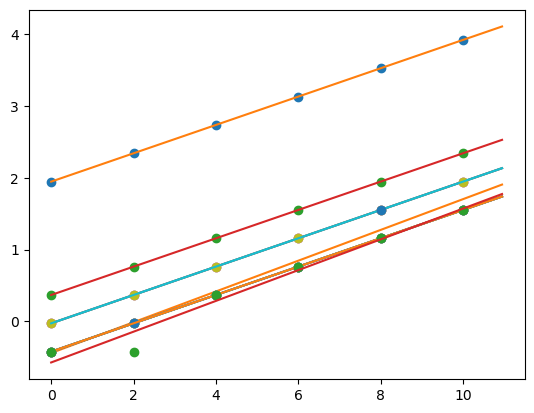

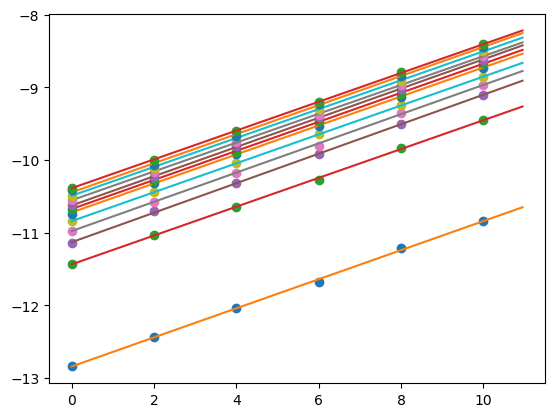

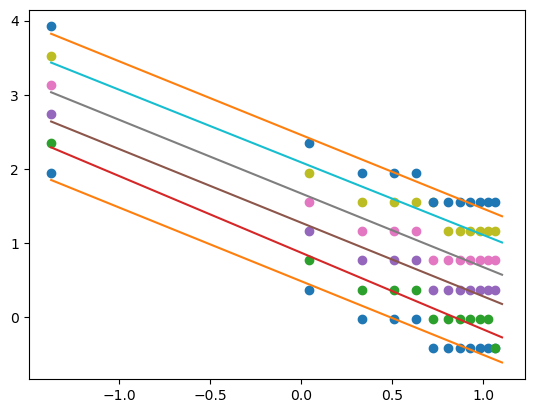

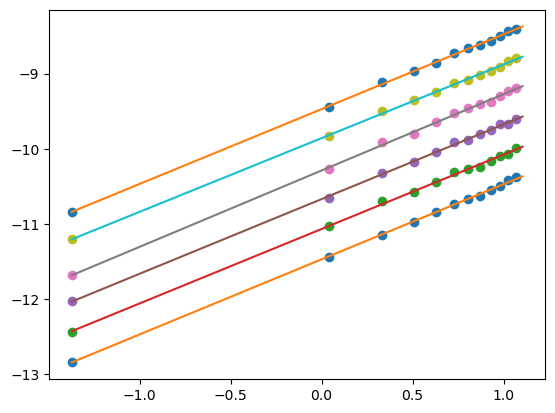

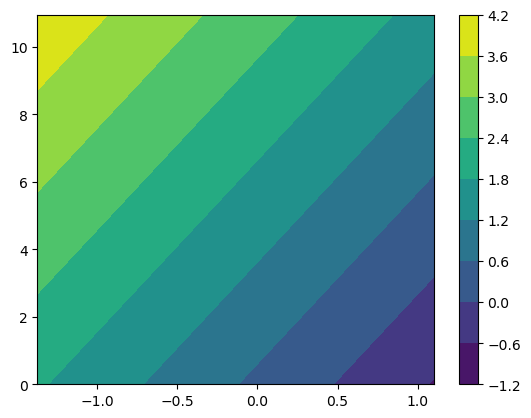

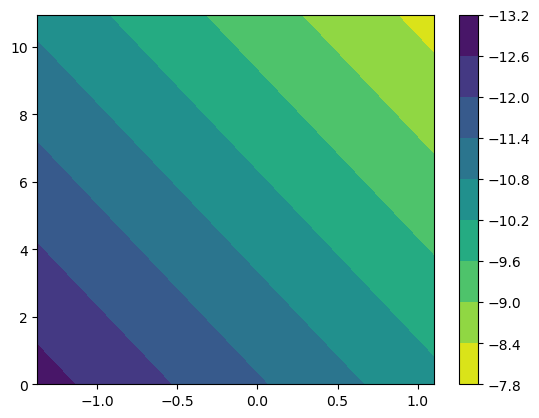

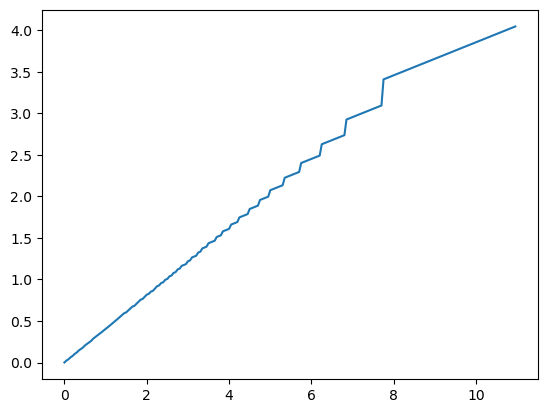

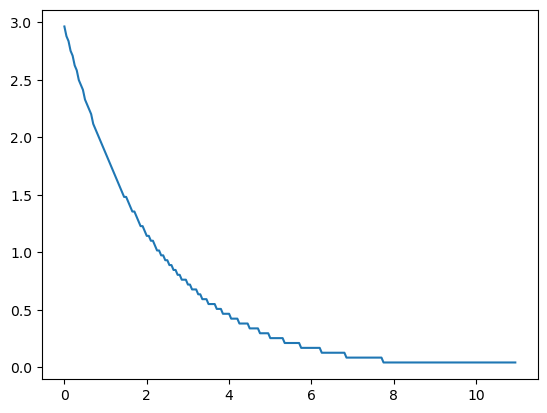

In [13]:
unarchive_data = np.concatenate((unarchive_data_mag0,unarchive_data_mag2,unarchive_data_mag4,unarchive_data_mag6,unarchive_data_mag8,unarchive_data_mag10))
t_min =  np.zeros([len(vmag_array),len(delta_wf)])
C_min =  np.zeros([len(vmag_array),len(delta_wf)])
for kk in range(0,len(vmag_array)):
    for qq in range(0,len(delta_wf)): 
        small_index = kk*(Ntimes*Nwf)+qq*Ntimes
        large_index = kk*(Ntimes*Nwf)+(qq+1)*Ntimes
        trou = unarchive_data[small_index:large_index]
        C_min[kk,qq] = np.min(trou)
        t_min[kk,qq] = time_array[trou == np.min(trou)]
def make_interp_plot(coarse_x,coarse_y,fine_x):
    z = np.polyfit(coarse_x, coarse_y, 1)
    fine_y = np.polyval(z, fine_x)
    plt.plot(coarse_x,coarse_y,'o')
    plt.plot(fine_x,fine_y)
    return (fine_y,z)
t_min_fine_vmag = np.zeros([len(vmag_array_fine),len(delta_wf)])
t_min_fit_vmag = np.zeros([len(delta_wf),2])
plt.figure()
for kk in range(0,len(delta_wf)):
    t_min_fine_vmag[:,kk],t_min_fit_vmag[kk] = make_interp_plot(vmag_array,np.log10(t_min[:,kk]),vmag_array_fine)
C_min_fine_vmag = np.zeros([len(vmag_array_fine),len(delta_wf)])
C_min_fit_vmag = np.zeros([len(delta_wf),2])
plt.figure()
for kk in range(0,len(delta_wf)):
    C_min_fine_vmag[:,kk],C_min_fit_vmag[kk,:] = make_interp_plot(vmag_array,np.log10(C_min[:,kk]),vmag_array_fine)
t_min_fine_wf = np.zeros([len(vmag_array),len(delta_wf_fine)])
t_min_fit_wf = np.zeros([len(vmag_array),2])
plt.figure()
for kk in range(0,len(vmag_array)):
    t_min_fine_wf[kk,:],t_min_fit_wf[kk,:] = make_interp_plot(np.log10(delta_wf),np.log10(t_min[kk,:]),np.log10(delta_wf_fine))
C_min_fine_wf = np.zeros([len(vmag_array),len(delta_wf_fine)])
C_min_fit_wf = np.zeros([len(vmag_array),2])
plt.figure()
for kk in range(0,len(vmag_array)):
    C_min_fine_wf[kk,:],C_min_fit_wf[kk,:] = make_interp_plot(np.log10(delta_wf),np.log10(C_min[kk,:]),np.log10(delta_wf_fine))
z_t_min_wf = np.polyfit(np.log10(delta_wf),t_min_fit_vmag[:,1], 1)
z_C_min_wf = np.polyfit(np.log10(delta_wf),C_min_fit_vmag[:,1], 1)
z_t_min_vmag = np.polyfit(vmag_array,t_min_fit_wf[:,1], 1)
z_C_min_vmag = np.polyfit(vmag_array,C_min_fit_wf[:,1], 1)
Nvmag =  len(vmag_array_fine)
Nwf_fine =  len(delta_wf_fine)
ones_vmag = np.ones([1,Nvmag])
ones_wf = np.ones([1,Nwf_fine])
delta_wf_line = np.dot(np.transpose([delta_wf_fine]),ones_vmag)
vmag_column = np.dot(np.transpose(ones_wf),[vmag_array_fine])
t_min_2D = z_t_min_vmag[1]+z_t_min_wf[0]*np.log10(delta_wf_line)+z_t_min_vmag[0]*vmag_column
C_min_2D = z_C_min_vmag[1]+z_C_min_wf[0]*np.log10(delta_wf_line)+z_C_min_vmag[0]*vmag_column
plt.figure()
plt.contourf(np.log10(delta_wf_line),vmag_column,t_min_2D)
plt.colorbar()
plt.figure()
plt.contourf(np.log10(delta_wf_line),vmag_column,C_min_2D)
plt.colorbar()
print(np.mean(t_min_fit_vmag[:,0]))
print(z_t_min_vmag)
print(np.mean(t_min_fit_wf[:,0]))
print(z_t_min_wf)
print(np.mean(C_min_fit_vmag[:,0]))
print(z_C_min_vmag)
print(np.mean(C_min_fit_wf[:,0]))
print(z_C_min_wf)
wf_req = np.zeros(Nvmag)
t_req = np.zeros(Nvmag)
for kk in range(0,Nvmag):
    if len(delta_wf_fine[C_min_2D[:,kk]<-11]) == 0: 
        wf_req_log = np.min(delta_wf_fine)
    else:
        wf_req_log = np.max(delta_wf_fine[C_min_2D[:,kk]<-11])
    wf_req[kk] = wf_req_log
    t_req_log = t_min_2D[delta_wf_fine == wf_req_log,kk]
    t_req[kk] = 10**(t_req_log)
plt.figure()
plt.plot(vmag_array_fine,np.log10(t_req))
plt.figure()
plt.plot(vmag_array_fine,wf_req)
t_req_4ring = t_req
wf_req_4ring = wf_req

## Five rings

In [14]:
NUM_RINGS = 5
WHICH_DM = 'seg_mirror'

# Define target contrast
C_TARGET = 1e-11

# Parameters for Temporal Ananlysis
sptype = CONFIG_ULTRA.get('target', 'sptype')
# Vmag = CONFIG_ULTRA.getfloat('target', 'Vmag')

minlam = CONFIG_ULTRA.getfloat('target', 'minlam') * u.nanometer
maxlam = CONFIG_ULTRA.getfloat('target', 'maxlam') * u.nanometer

dark_current = CONFIG_ULTRA.getfloat('detector', 'dark_current')
CIC = CONFIG_ULTRA.getfloat('detector', 'dark_current')

# Set close loop parameters.
detector_noise = CONFIG_ULTRA.getfloat('detector', 'detector_noise')
niter = CONFIG_ULTRA.getint('close_loop', 'niter')
TimeMinus = CONFIG_ULTRA.getfloat('close_loop', 'TimeMinus')
TimePlus = CONFIG_ULTRA.getfloat('close_loop', 'TimePlus')
Ntimes = CONFIG_ULTRA.getint('close_loop', 'Ntimes')
Nwavescale = CONFIG_ULTRA.getfloat('close_loop', 'Nwavescale')

# if WHICH_DM == 'harris_seg_mirror':
#     fpath = CONFIG_PASTIS.get('LUVOIR', 'harris_data_path')  # path to Harris spreadsheet
#     pad_orientations = np.pi / 2 * np.ones(CONFIG_PASTIS.getint('LUVOIR', 'nb_subapertures'))
#     DM_SPEC = (fpath, pad_orientations, True, False, False)
#     NUM_MODES = 7

# DM_SPEC = 7
# NUM_MODES = 7
# run_matrix = MatrixEfieldHex(which_dm=WHICH_DM, dm_spec=DM_SPEC, num_rings=NUM_RINGS,
#                              calc_science=True, calc_wfs=True,
#                              initial_path=CONFIG_PASTIS.get('local', 'local_data_path'), norm_one_photon=True)

# run_matrix.calc()
# data_dir = run_matrix.overall_dir
# print(f'All saved to {data_dir}.')

# tel = run_matrix.simulator


# unaber_psf = fits.getdata(os.path.join(data_dir, 'unaberrated_coro_psf.fits'))  # already normalized to max of direct psf
# dh_mask_shaped = tel.dh_mask.shaped
# contrast_floor = dh_mean(unaber_psf, dh_mask_shaped)

In [15]:
data_dir = '/Users/pueyo/data_from_repos/pastis_data/2023-05-26T21-52-46_hexringtelescope/'

vmag_array = np.arange(0, 11, 2)
wavescale_min = 1    
wavescale_max = 301
wavescale_step = 25
wavescale_array =  np.arange(wavescale_min, wavescale_max, wavescale_step)
N_wave = len(wavescale_array)
TimeMinus = -2
TimePlus = 5.5
Ntimes = 20
time_array = np.logspace(TimeMinus, TimePlus, Ntimes)

wavescale_step_fine = 1
wavescale_array_fine =  np.arange(wavescale_min, wavescale_max, wavescale_step_fine)
vmag_array_fine = np.arange(0, 11, 0.05)

mus = np.genfromtxt(data_dir+'mus_Hex_5_1e-11.csv',delimiter=',')
Qs = np.diag(np.asarray(mus ** 2))
delta_wf = []
for wavescale in range(wavescale_min, wavescale_max, wavescale_step):
    wf = np.sqrt(np.mean(np.diag(0.0001 * wavescale ** 2 * Qs))) * 1e3
    delta_wf.append(wf)
delta_wf = np.array(delta_wf)
Nwf = len(delta_wf)
delta_wf_fine = []
for wavescale in range(wavescale_min, wavescale_max, wavescale_step_fine):
    wf = np.sqrt(np.mean(np.diag(0.0001 * wavescale ** 2 * Qs))) * 1e3
    delta_wf_fine.append(wf)
delta_wf_fine = np.array(delta_wf_fine)

unarchive_data_mag0 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_5_0.csv',delimiter=',')
unarchive_data_mag2 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_5_2.csv',delimiter=',')
unarchive_data_mag4 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_5_4.csv',delimiter=',')
unarchive_data_mag6 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_5_6.csv',delimiter=',')
unarchive_data_mag8 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_5_8.csv',delimiter=',')
unarchive_data_mag10 = np.genfromtxt(data_dir+'contrast_wf_1e-11_1_301_25_5_10.csv',delimiter=',')

### just make the plots

0.200187969924812
[0.20115301 0.61161807]
-0.9998001312090324
[-0.99269295  0.61161807]
0.20048691370540417
[  0.20073589 -11.60268902]
1.0010105423335776
[  1.00284415 -11.60268902]


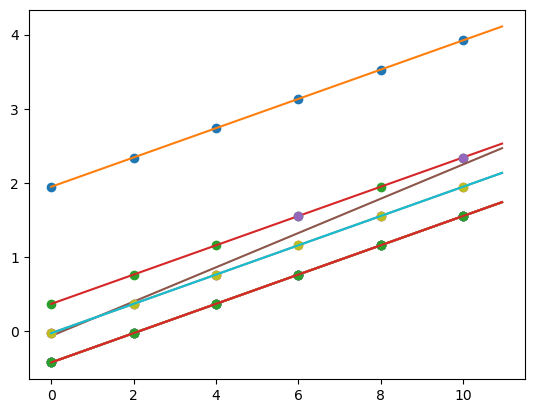

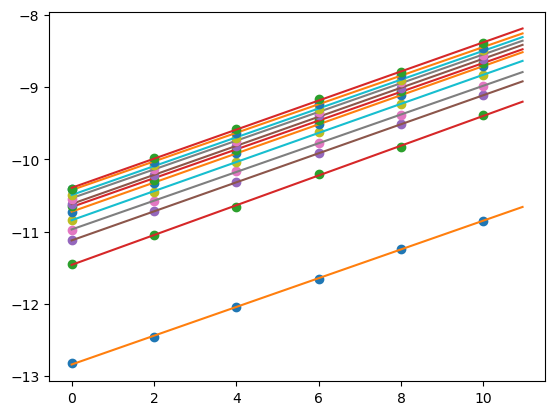

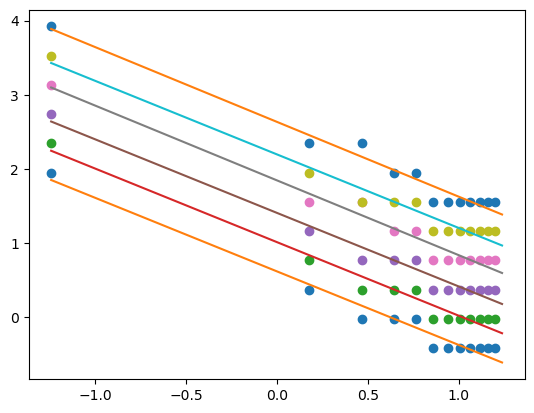

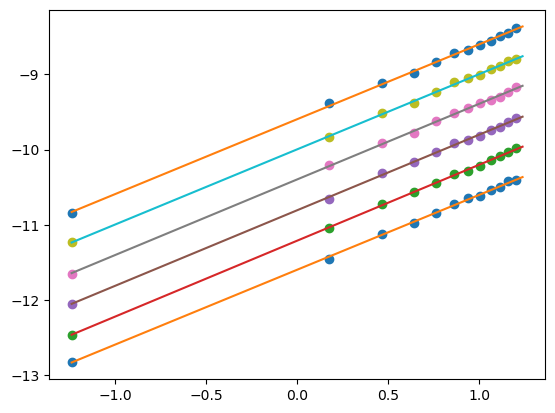

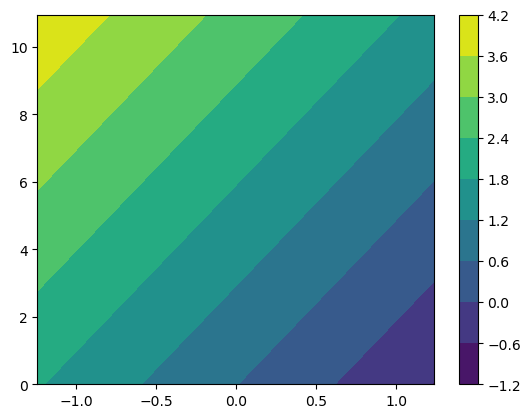

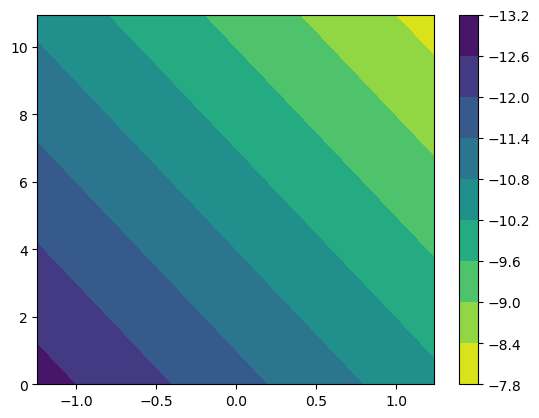

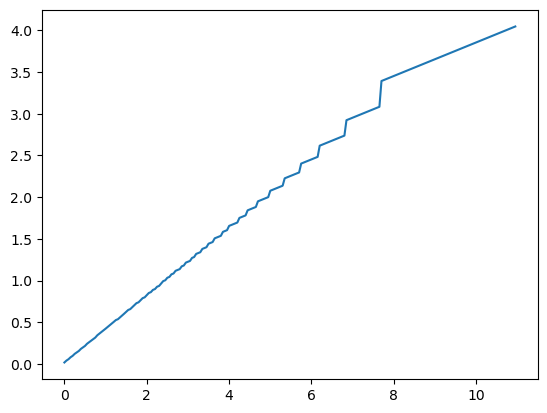

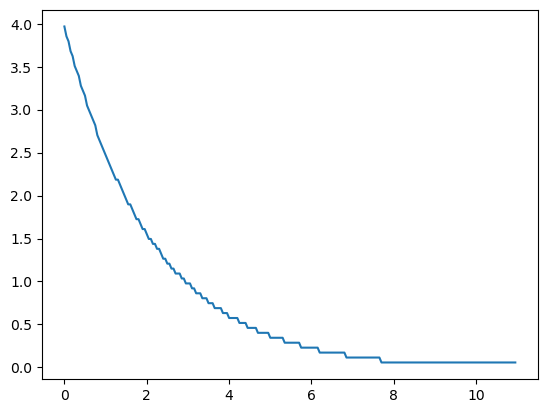

In [16]:
unarchive_data = np.concatenate((unarchive_data_mag0,unarchive_data_mag2,unarchive_data_mag4,unarchive_data_mag6,unarchive_data_mag8,unarchive_data_mag10))
t_min =  np.zeros([len(vmag_array),len(delta_wf)])
C_min =  np.zeros([len(vmag_array),len(delta_wf)])
for kk in range(0,len(vmag_array)):
    for qq in range(0,len(delta_wf)): 
        small_index = kk*(Ntimes*Nwf)+qq*Ntimes
        large_index = kk*(Ntimes*Nwf)+(qq+1)*Ntimes
        trou = unarchive_data[small_index:large_index]
        C_min[kk,qq] = np.min(trou)
        t_min[kk,qq] = time_array[trou == np.min(trou)]
def make_interp_plot(coarse_x,coarse_y,fine_x):
    z = np.polyfit(coarse_x, coarse_y, 1)
    fine_y = np.polyval(z, fine_x)
    plt.plot(coarse_x,coarse_y,'o')
    plt.plot(fine_x,fine_y)
    return (fine_y,z)
t_min_fine_vmag = np.zeros([len(vmag_array_fine),len(delta_wf)])
t_min_fit_vmag = np.zeros([len(delta_wf),2])
plt.figure()
for kk in range(0,len(delta_wf)):
    t_min_fine_vmag[:,kk],t_min_fit_vmag[kk] = make_interp_plot(vmag_array,np.log10(t_min[:,kk]),vmag_array_fine)
C_min_fine_vmag = np.zeros([len(vmag_array_fine),len(delta_wf)])
C_min_fit_vmag = np.zeros([len(delta_wf),2])
plt.figure()
for kk in range(0,len(delta_wf)):
    C_min_fine_vmag[:,kk],C_min_fit_vmag[kk,:] = make_interp_plot(vmag_array,np.log10(C_min[:,kk]),vmag_array_fine)
t_min_fine_wf = np.zeros([len(vmag_array),len(delta_wf_fine)])
t_min_fit_wf = np.zeros([len(vmag_array),2])
plt.figure()
for kk in range(0,len(vmag_array)):
    t_min_fine_wf[kk,:],t_min_fit_wf[kk,:] = make_interp_plot(np.log10(delta_wf),np.log10(t_min[kk,:]),np.log10(delta_wf_fine))
C_min_fine_wf = np.zeros([len(vmag_array),len(delta_wf_fine)])
C_min_fit_wf = np.zeros([len(vmag_array),2])
plt.figure()
for kk in range(0,len(vmag_array)):
    C_min_fine_wf[kk,:],C_min_fit_wf[kk,:] = make_interp_plot(np.log10(delta_wf),np.log10(C_min[kk,:]),np.log10(delta_wf_fine))
z_t_min_wf = np.polyfit(np.log10(delta_wf),t_min_fit_vmag[:,1], 1)
z_C_min_wf = np.polyfit(np.log10(delta_wf),C_min_fit_vmag[:,1], 1)
z_t_min_vmag = np.polyfit(vmag_array,t_min_fit_wf[:,1], 1)
z_C_min_vmag = np.polyfit(vmag_array,C_min_fit_wf[:,1], 1)
Nvmag =  len(vmag_array_fine)
Nwf_fine =  len(delta_wf_fine)
ones_vmag = np.ones([1,Nvmag])
ones_wf = np.ones([1,Nwf_fine])
delta_wf_line = np.dot(np.transpose([delta_wf_fine]),ones_vmag)
vmag_column = np.dot(np.transpose(ones_wf),[vmag_array_fine])
t_min_2D = z_t_min_vmag[1]+z_t_min_wf[0]*np.log10(delta_wf_line)+z_t_min_vmag[0]*vmag_column
C_min_2D = z_C_min_vmag[1]+z_C_min_wf[0]*np.log10(delta_wf_line)+z_C_min_vmag[0]*vmag_column
plt.figure()
plt.contourf(np.log10(delta_wf_line),vmag_column,t_min_2D)
plt.colorbar()
plt.figure()
plt.contourf(np.log10(delta_wf_line),vmag_column,C_min_2D)
plt.colorbar()
print(np.mean(t_min_fit_vmag[:,0]))
print(z_t_min_vmag)
print(np.mean(t_min_fit_wf[:,0]))
print(z_t_min_wf)
print(np.mean(C_min_fit_vmag[:,0]))
print(z_C_min_vmag)
print(np.mean(C_min_fit_wf[:,0]))
print(z_C_min_wf)
wf_req = np.zeros(Nvmag)
t_req = np.zeros(Nvmag)
for kk in range(0,Nvmag):
    if len(delta_wf_fine[C_min_2D[:,kk]<-11]) == 0: 
        wf_req_log = np.min(delta_wf_fine)
    else:
        wf_req_log = np.max(delta_wf_fine[C_min_2D[:,kk]<-11])
    wf_req[kk] = wf_req_log
    t_req_log = t_min_2D[delta_wf_fine == wf_req_log,kk]
    t_req[kk] = 10**(t_req_log)
plt.figure()
plt.plot(vmag_array_fine,np.log10(t_req))
plt.figure()
plt.plot(vmag_array_fine,wf_req)
t_req_5ring = t_req
wf_req_5ring = wf_req

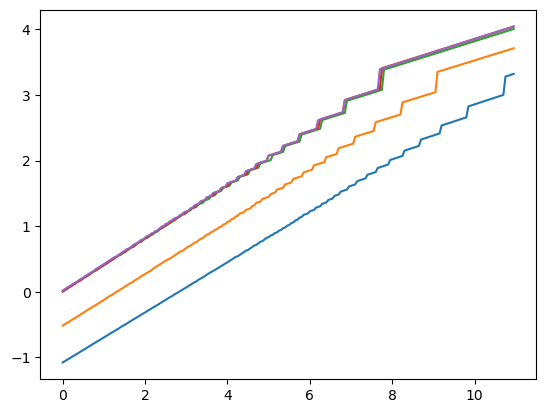

In [17]:
plt.plot(vmag_array_fine,np.log10(t_req_1ring))
plt.plot(vmag_array_fine,np.log10(t_req_2ring))
plt.plot(vmag_array_fine,np.log10(t_req_3ring))
plt.plot(vmag_array_fine,np.log10(t_req_4ring))
plt.plot(vmag_array_fine,np.log10(t_req_5ring))

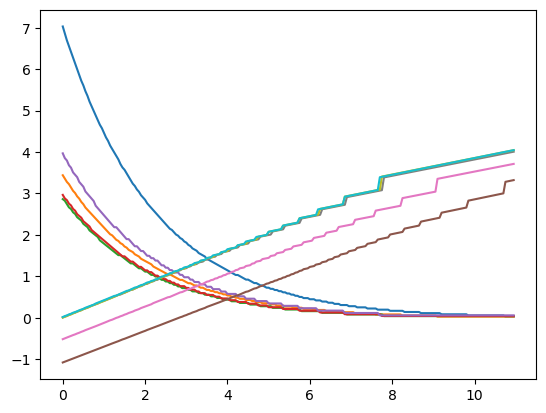

In [18]:
plt.plot(vmag_array_fine,wf_req_1ring)
plt.plot(vmag_array_fine,wf_req_2ring)
plt.plot(vmag_array_fine,wf_req_3ring)
plt.plot(vmag_array_fine,wf_req_4ring)
plt.plot(vmag_array_fine,wf_req_5ring)
plt.plot(vmag_array_fine,np.log10(t_req_1ring))
plt.plot(vmag_array_fine,np.log10(t_req_2ring))
plt.plot(vmag_array_fine,np.log10(t_req_3ring))
plt.plot(vmag_array_fine,np.log10(t_req_4ring))
plt.plot(vmag_array_fine,np.log10(t_req_5ring))


In [19]:
## Add colorbar to lines

In [33]:
plt.rcParams['font.family'] = "Lato"
plt.rcParams["font.sans-serif"] = ["Hershey"]
plt.rcParams["text.usetex"] = True
# plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

In [25]:
# plt.rcParams['font.family'] = "sans-serif"
# plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
# plt.rcParams["text.usetex"] = True
# plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
# plt.rcParams['font.size'] = 16
# plt.rcParams['axes.labelsize'] = 22
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['xtick.labelsize'] = 16
# plt.rcParams['ytick.labelsize'] = 16
# plt.rcParams['legend.fontsize'] = 16
# plt.rcParams['figure.titlesize'] = 16

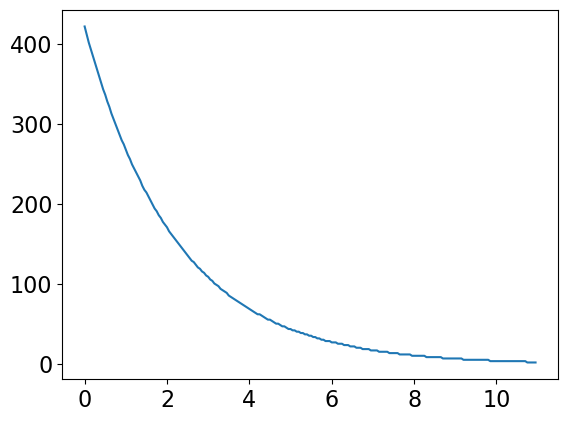

In [30]:
plt.plot(vmag_array_fine,60*(wf_req_1ring))


In [21]:
wf_req_1ring.shape

(220,)

In [22]:
vmag_array_fine.shape

(220,)

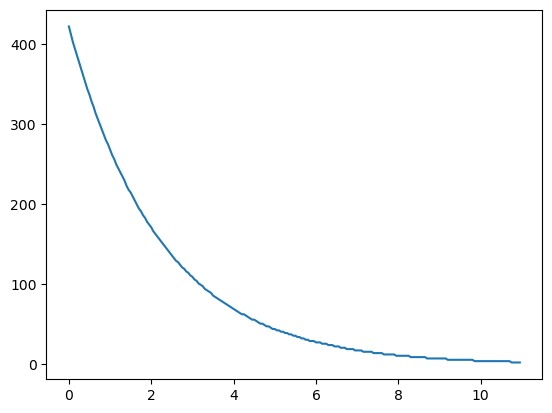

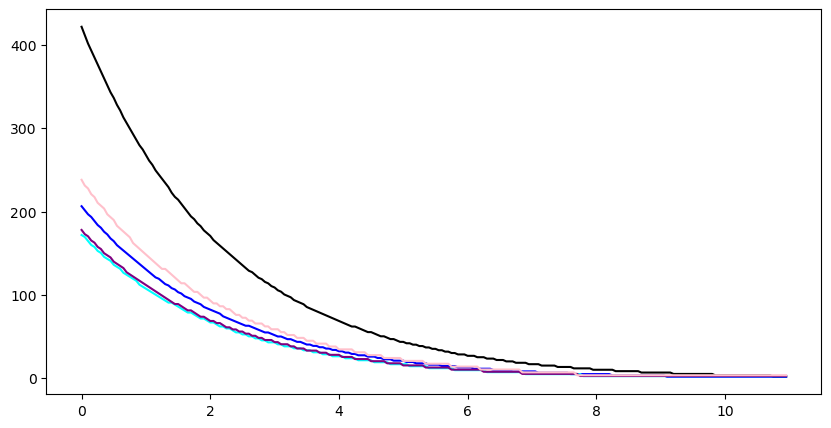

In [24]:
fig,ax0, = plt.subplots(1,figsize=(10, 5))
plt.plot(vmag_array_fine,60*(wf_req_1ring),color='black',label =' One ring')
plt.plot(vmag_array_fine,60*(wf_req_2ring),color='blue',label =' Two rings')
plt.plot(vmag_array_fine,60*(wf_req_3ring),color='cyan',label =' Three rings')
plt.plot(vmag_array_fine,60*(wf_req_4ring),color='purple',label =' Four rings')
plt.plot(vmag_array_fine,60*(wf_req_5ring),color='pink', label =' Five rings')
# ax0.grid()
# ax0.set(xlabel = 'Primary magnitude',ylabel = 'Requirement in pm/min',title = 'Closed loop requiremnts')
# ax0.legend()

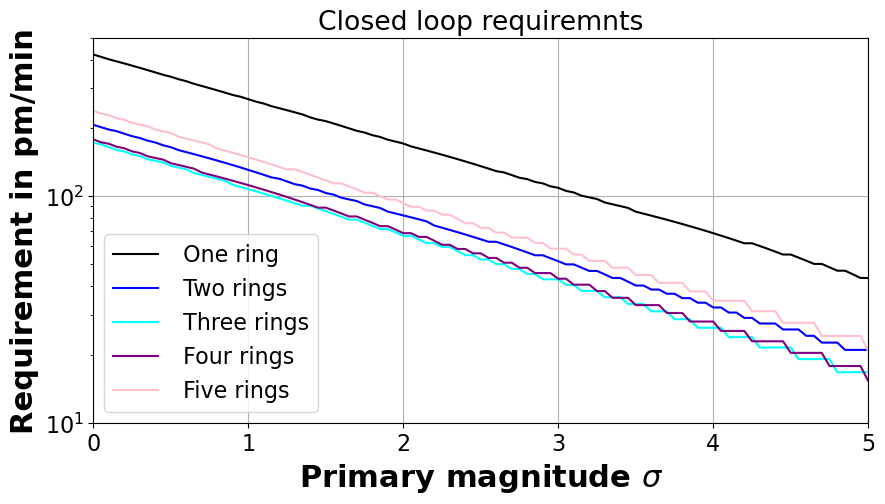

In [32]:
fig,ax0, = plt.subplots(1,figsize=(10, 5))
plt.plot(vmag_array_fine,60*(wf_req_1ring),color='black',label =' One ring')
plt.plot(vmag_array_fine,60*(wf_req_2ring),color='blue',label =' Two rings')
plt.plot(vmag_array_fine,60*(wf_req_3ring),color='cyan',label =' Three rings')
plt.plot(vmag_array_fine,60*(wf_req_4ring),color='purple',label =' Four rings')
plt.plot(vmag_array_fine,60*(wf_req_5ring),color='pink', label =' Five rings')
ax0.grid()
ax0.semilogy()
ax0.set_xlim(0,5)
ax0.set_ylim(10,500)
ax0.set(xlabel = 'Primary magnitude',ylabel = 'Requirement in pm/min',title = 'Closed loop requiremnts')
ax0.legend()

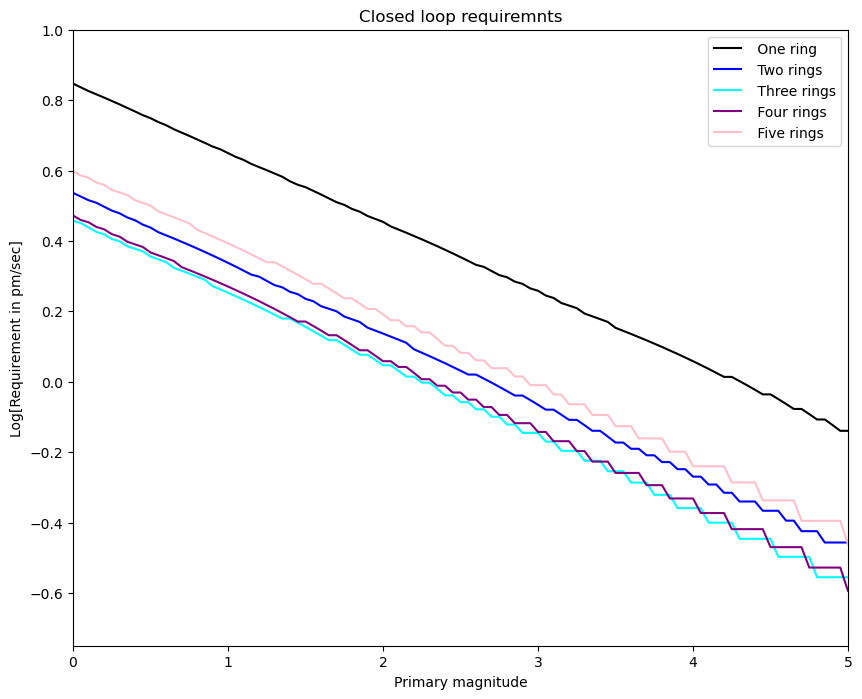

In [26]:
fig,ax0, = plt.subplots(1,figsize=(10, 8))
plt.plot(vmag_array_fine,np.log10(wf_req_1ring),color='black',label =' One ring')
plt.plot(vmag_array_fine,np.log10(wf_req_2ring),color='blue',label =' Two rings')
plt.plot(vmag_array_fine,np.log10(wf_req_3ring),color='cyan',label =' Three rings')
plt.plot(vmag_array_fine,np.log10(wf_req_4ring),color='purple',label =' Four rings')
plt.plot(vmag_array_fine,np.log10(wf_req_5ring),color='pink', label =' Five rings')
ax0.set_xlim(0,5)
ax0.set_ylim(-0.75,1)
ax0.set(xlabel = 'Primary magnitude',ylabel = 'Log[Requirement in pm/sec]',title = 'Closed loop requiremnts')
ax0.legend()